Epoch 1/20, Total VAE Loss: 26190.6917, Reconstruction Loss: 26190.0565, KL Loss: 635.1814
Epoch 2/20, Total VAE Loss: 26211.6690, Reconstruction Loss: 26210.7731, KL Loss: 895.8808
Epoch 3/20, Total VAE Loss: 15192.1123, Reconstruction Loss: 15191.0446, KL Loss: 1067.7135
Epoch 4/20, Total VAE Loss: 9379.4967, Reconstruction Loss: 9378.4545, KL Loss: 1042.2303
Epoch 5/20, Total VAE Loss: 6572.0927, Reconstruction Loss: 6570.9551, KL Loss: 1137.6017
Epoch 6/20, Total VAE Loss: 4942.9067, Reconstruction Loss: 4941.7195, KL Loss: 1187.2463
Epoch 7/20, Total VAE Loss: 3847.2916, Reconstruction Loss: 3846.1060, KL Loss: 1185.5127
Epoch 8/20, Total VAE Loss: 2998.8839, Reconstruction Loss: 2997.6996, KL Loss: 1184.2262
Epoch 9/20, Total VAE Loss: 2465.7570, Reconstruction Loss: 2464.5738, KL Loss: 1183.1938
Epoch 10/20, Total VAE Loss: 2029.2419, Reconstruction Loss: 2028.0597, KL Loss: 1182.1596
Epoch 11/20, Total VAE Loss: 1676.1748, Reconstruction Loss: 1674.9938, KL Loss: 1181.0534
Epoc

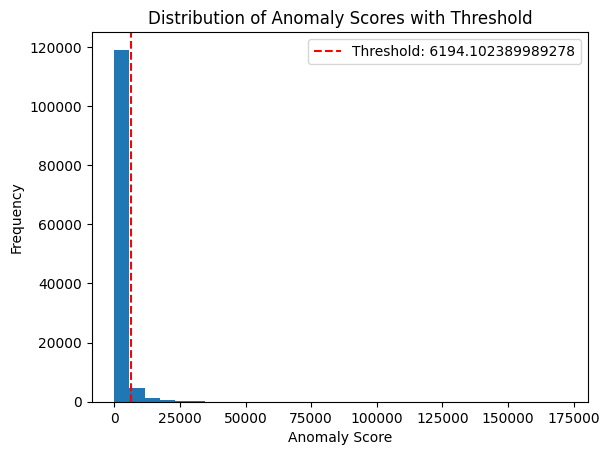

Number of anomalies detected: 6299 out of 125973


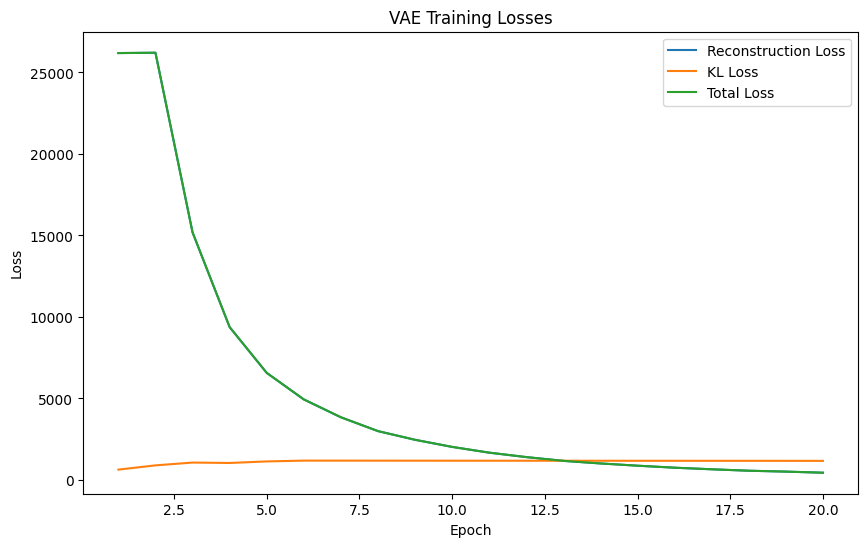

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from vae import VAE 
from data_loader import load_network_traffic_from_txt, load_network_traffic_data

# X_traffic = load_network_traffic_from_txt('datasets/Train.txt')  # Adjust file path as needed
# scaler = StandardScaler()
# X_traffic = scaler.fit_transform(X_traffic)

# X_train, X_val = X_traffic[:8000], X_traffic[8000:]

X_train, x_val = load_network_traffic_data()

input_size = X_train.shape[1]
latent_size = 20
vae = VAE(input_size=input_size, latent_size=latent_size)

# Training parameters
epochs = 20
kl_loss_weight = 0.001
learning_rate = 0.0001
anomaly_threshold = 0.3
reconstruction_losses = []
kl_losses = []
total_losses = []
all_predictions = []
anomalies = []

# Training loop for VAE
for epoch in range(epochs):
    reconstruction, z_mean, z_log_var = vae.forward_propagation(X_train)
    
    reconstruction_loss = np.mean((X_train - reconstruction) ** 2, axis=1)

    kl_loss = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))
    vae_loss = reconstruction_loss + kl_loss_weight * kl_loss
    vae_loss = np.mean(vae_loss)
    reconstruction_loss = np.mean(reconstruction_loss)
    kl_loss = np.mean(kl_loss)
    
    vae.backward_propagation(X_train, reconstruction, z_mean, z_log_var, learning_rate)
    # predictions = (reconstruction_loss > anomaly_threshold).astype(int)
    # predictions = np.array(predictions)
    # anomaly_score = reconstruction_loss + kl_loss
    # print(anomaly_score)
    # anomalies_predictions = anomaly_score > anomaly_threshold
    reconstruction_losses.append(reconstruction_loss)
    kl_losses.append(kl_loss)
    total_losses.append(vae_loss)
    # anomalies.append(anomalies_predictions)
    
    print(f"Epoch {epoch+1}/{epochs}, Total VAE Loss: {vae_loss:.4f}, "
          f"Reconstruction Loss: {reconstruction_loss:.4f}, KL Loss: {kl_loss:.4f}")
    
predictions = (reconstruction_loss > anomaly_threshold).astype(int)
all_predictions.append(predictions)

anomaly_scores = []
for sample in X_train:  # Replace 'test_set' with your actual data
    reconstruction, z_mean, z_log_var = vae.forward_propagation(sample)
    reconstruction_loss = np.mean((sample - reconstruction) ** 2)
    kl_loss = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))
    total_loss = reconstruction_loss + kl_loss
    anomaly_scores.append(total_loss)

# Set a threshold based on the anomaly scores
threshold = np.percentile(anomaly_scores, 95)

# Identify anomalies
anomalies = [score > threshold for score in anomaly_scores]

# Plot or analyze anomalies as needed
plt.hist(anomaly_scores, bins=30)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')
plt.legend()
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores with Threshold")
plt.show()

# Print the number of anomalies detected
print(f"Number of anomalies detected: {sum(anomalies)} out of {len(anomaly_scores)}")
# Total loss as the anomaly score
# anomaly_score = reconstruction_loss + kl_loss

# plt.hist(anomalies, bins=50)
# plt.xlabel('Anomaly Score')
# plt.ylabel('Frequency')
# plt.title('Distribution of Anomaly Scores')
# plt.show()

# Flag as anomaly if the anomaly score exceeds the threshold
# anomalies = anomaly_score > anomaly_threshold
# print(anomalies)
# num_anomalies = np.sum(anomalies)
# print(num_anomalies)

# print(f"Number of anomalies detected: {num_anomalies} / {len(x_val)}")
# print(f"Anomaly score (sample): {anomaly_score[:10]}")
# print(f"Anomalies (sample): {anomalies[:10]}")
# accuracy = accuracy_score(x_val, all_predictions)
# precision = precision_score(x_val, all_predictions)
# recall = recall_score(x_val, all_predictions)

# Plotting the VAE losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), reconstruction_losses, label='Reconstruction Loss')
plt.plot(range(1, epochs + 1), kl_losses, label='KL Loss')
plt.plot(range(1, epochs + 1), total_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Losses')
plt.legend()
plt.show()
